In [1]:
# Import Libraries and create Variables
from dotenv import load_dotenv
import os
import sys
import pandas as pd 
import numpy as np 
import psycopg2 as ps
from scipy.stats import anderson
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
import warnings


def vis_distro(df, fname, n_rows, n_cols):
    fig=plt.figure()
    for i, feat_name in enumerate(fname):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[feat_name].hist(bins=5,ax=ax)
        ax.set_title('Distro for {}'.format(feat_name))
    fig.tight_layout() 
    plt.show()

#instantiate dotenv to bring in environement variables
load_dotenv()
#Prevent Deperecation and User Warnings as these do not pertain to this analysis
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  
# Create db Connection functions 

def db_connect():

    # connect to database 
    conn = None
    try:
        print('connecting to database.....')
        conn= ps.connect(
    host=os.environ['DB_PATH'],
    database=os.environ['DB_NAME'],
    user=os.environ['DB_USERNAME'],
    password=os.environ['DB_PASSWORD'],
    port = os.environ['DB_PORT']
                        )
    except (Exception, ps.DatabaseError) as error:
        print(error)
        sys.exit(1)
    print(f'Connected to Database "{os.environ["DB_NAME"]}"')
    
    return conn

print("Environment Loaded")

Environment Loaded


In [2]:
#Establish Variables, create DataFrame and print DF description
export_path = os.environ['EXPORT_PATH'],
    #Connect to Databaser
conn = db_connect()
    #Write Query
	
transaction_query = """with aisle as (select Distinct 
loc_aisle, 
max(loc_y) max_y,
Min(loc_y) min_y
from d214.locationDim
group by loc_aisle)
select 
trn.start_time, 
trn.end_time,
trn.usr_id, 
trn.device_id, 
trn.act_id, 
trn.pickup_flg, 
case when fr_loc.loc_aisle = to_loc.loc_aisle then 
	abs(fr_loc.loc_y-to_loc.loc_y)
else 
	abs(fr_loc.loc_y - fr_aisle.max_y)+
	abs(fr_loc.loc_x - to_loc.loc_x)+
	abs(to_loc.loc_y - to_aisle.max_y)
end as trv_dist,
fr_loc.loc_lvl fr_lvl,
to_loc.loc_lvl to_lvl,
trn.case_count, 
trn.pallet_qty, 
trn.cube, 
trn.wght, 
trn.task_seconds
from d214.transactionfact trn 
join d214.locationDim fr_loc
on fr_loc.loc_id = trn.fr_loc_id
join d214.locationDim to_loc 
on to_loc.loc_id = trn.to_loc_id
join aisle fr_aisle
on fr_aisle.loc_aisle = fr_loc.loc_aisle
join aisle to_aisle
on to_aisle.loc_aisle = to_loc.loc_aisle
where trn.task_seconds > 20
and trn.task_seconds < 4000
and case when fr_loc.loc_aisle = to_loc.loc_aisle then 
	abs(fr_loc.loc_y-to_loc.loc_y)
else 
	abs(fr_loc.loc_y - fr_aisle.max_y)+
	abs(fr_loc.loc_x - to_loc.loc_x)+
	abs(to_loc.loc_y - to_aisle.max_y)
end > 0"""

trn_df = pd.read_sql(transaction_query,conn).dropna(axis=0)

print('DataFrame Loaded')


connecting to database.....
Connected to Database "postgres"
DataFrame Loaded


In [3]:
#Print DF Info
print('DataFrame Info')
print(trn_df.info())



DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123874 entries, 0 to 123873
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   start_time    123874 non-null  datetime64[ns]
 1   end_time      123874 non-null  datetime64[ns]
 2   usr_id        123874 non-null  int64         
 3   device_id     123874 non-null  int64         
 4   act_id        123874 non-null  int64         
 5   pickup_flg    123874 non-null  bool          
 6   trv_dist      123874 non-null  int64         
 7   fr_lvl        123874 non-null  int64         
 8   to_lvl        123874 non-null  int64         
 9   case_count    123874 non-null  float64       
 10  pallet_qty    123874 non-null  float64       
 11  cube          123874 non-null  float64       
 12  wght          123874 non-null  float64       
 13  task_seconds  123874 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(4), int64(7)
m

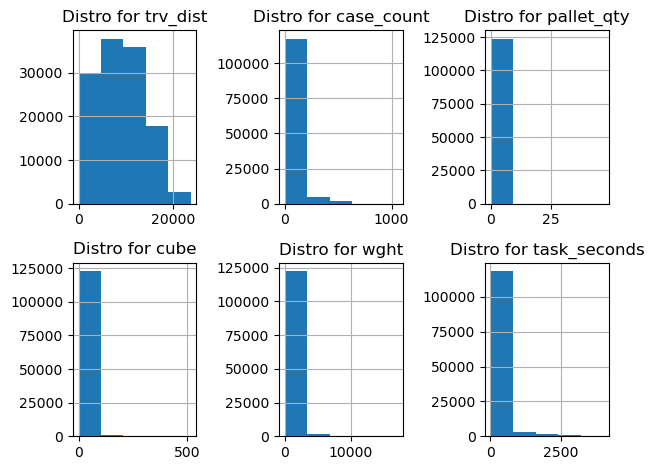

In [4]:
#Visualize Data
non_cat_features = ['trv_dist','case_count','pallet_qty','cube','wght','task_seconds']
vis_distro(trn_df,trn_df[non_cat_features],2,3)

In [5]:
#Outlier Analysis 


def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn,[25,75])
    IQR = Q3-Q1
    lower_range = Q1-(1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range



def olaTreatment(df,featList):
    for i in df[featList]:
        print(f'Processing {i}....', f'Shape: {df.shape}')
        lower,upper = outlier_treatment(df[i])    
        df.drop(df[(df[i]> upper)|(df[i] < lower)].index,axis=0,inplace=True)  
    
    print('Shape after OLA: {}'.format(df.shape))  

        
 
    return df

cp = olaTreatment( trn_df[trn_df['act_id']==1000001],non_cat_features)
pp = olaTreatment( trn_df[trn_df['act_id']==1000002],non_cat_features)
rp = olaTreatment( trn_df[trn_df['act_id']==1000003],non_cat_features)

trn_df = cp.append(pp,ignore_index=True)
trn_df = trn_df.append(rp,ignore_index=True)

print(trn_df.info())


Processing trv_dist.... Shape: (50040, 14)
Processing case_count.... Shape: (49985, 14)
Processing pallet_qty.... Shape: (45652, 14)
Processing cube.... Shape: (42289, 14)
Processing wght.... Shape: (39883, 14)
Processing task_seconds.... Shape: (37787, 14)
Shape after OLA: (34531, 14)
Processing trv_dist.... Shape: (63003, 14)
Processing case_count.... Shape: (61528, 14)
Processing pallet_qty.... Shape: (59988, 14)
Processing cube.... Shape: (52485, 14)
Processing wght.... Shape: (51649, 14)
Processing task_seconds.... Shape: (47756, 14)
Shape after OLA: (43684, 14)
Processing trv_dist.... Shape: (10831, 14)
Processing case_count.... Shape: (10649, 14)
Processing pallet_qty.... Shape: (9269, 14)
Processing cube.... Shape: (7394, 14)
Processing wght.... Shape: (7122, 14)
Processing task_seconds.... Shape: (7122, 14)
Shape after OLA: (6421, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84636 entries, 0 to 84635
Data columns (total 14 columns):
 #   Column        Non-Null Count  

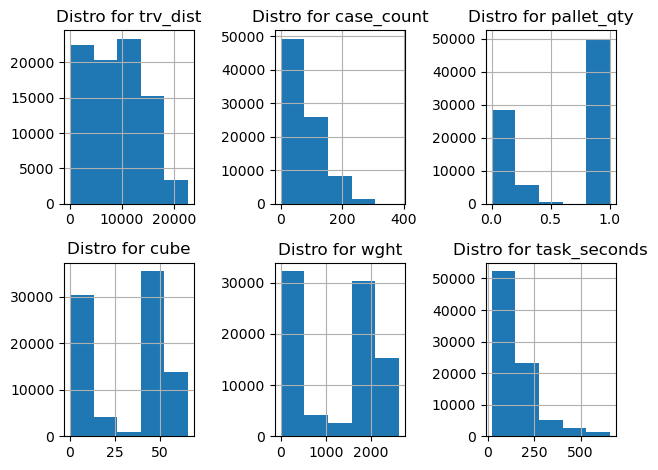

In [6]:
vis_distro(trn_df,trn_df[non_cat_features],2,3)

In [7]:
#OneHot Encode Categorical Features

drop_cols = ['start_time','end_time','device_id','usr_id']
cat_cols = ['act_id','fr_lvl','to_lvl']

for i in cat_cols:
    dummies = pd.get_dummies(trn_df[i],prefix=i,prefix_sep='/')
    trn_df[dummies.columns] = dummies
    trn_df = trn_df.drop([i], axis=1)

trn_df = trn_df.drop(drop_cols,axis=1)
print(trn_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84636 entries, 0 to 84635
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pickup_flg      84636 non-null  bool   
 1   trv_dist        84636 non-null  int64  
 2   case_count      84636 non-null  float64
 3   pallet_qty      84636 non-null  float64
 4   cube            84636 non-null  float64
 5   wght            84636 non-null  float64
 6   task_seconds    84636 non-null  int64  
 7   act_id/1000001  84636 non-null  uint8  
 8   act_id/1000002  84636 non-null  uint8  
 9   act_id/1000003  84636 non-null  uint8  
 10  fr_lvl/1        84636 non-null  uint8  
 11  fr_lvl/2        84636 non-null  uint8  
 12  fr_lvl/3        84636 non-null  uint8  
 13  fr_lvl/4        84636 non-null  uint8  
 14  fr_lvl/5        84636 non-null  uint8  
 15  fr_lvl/6        84636 non-null  uint8  
 16  to_lvl/1        84636 non-null  uint8  
 17  to_lvl/2        84636 non-null 

In [8]:
print(trn_df.columns)

Index(['pickup_flg', 'trv_dist', 'case_count', 'pallet_qty', 'cube', 'wght',
       'task_seconds', 'act_id/1000001', 'act_id/1000002', 'act_id/1000003',
       'fr_lvl/1', 'fr_lvl/2', 'fr_lvl/3', 'fr_lvl/4', 'fr_lvl/5', 'fr_lvl/6',
       'to_lvl/1', 'to_lvl/2', 'to_lvl/3', 'to_lvl/4', 'to_lvl/5', 'to_lvl/6'],
      dtype='object')


In [9]:
# Leverage Anderson Darling to statistically check for normality

for feature in non_cat_features:
    result = anderson(trn_df[feature])    

    # Extract relevant information
    test_statistic = round(result.statistic,4)
    critical_values = result.critical_values
    significance_levels = result.significance_level

     # Find the index corresponding to the 5% significance level
    index_5_percent = (significance_levels == 5).nonzero()[0][0]

    # Extract the critical value at 5%
    critical_value_5_percent = critical_values[index_5_percent]

    # Display or use the extracted information
    print(f'Anderson-Darling test result for {feature}:')
    print(f'Test Statistic: {test_statistic}')
    print(f'Critical Value at 5%: {critical_value_5_percent}')

Anderson-Darling test result for trv_dist:
Test Statistic: 773.1333
Critical Value at 5%: 0.787
Anderson-Darling test result for case_count:
Test Statistic: 2330.8719
Critical Value at 5%: 0.787
Anderson-Darling test result for pallet_qty:
Test Statistic: 12993.9457
Critical Value at 5%: 0.787
Anderson-Darling test result for cube:
Test Statistic: 6602.452
Critical Value at 5%: 0.787


Anderson-Darling test result for wght:
Test Statistic: 5777.5764
Critical Value at 5%: 0.787
Anderson-Darling test result for task_seconds:
Test Statistic: 4350.2994
Critical Value at 5%: 0.787


In [13]:
#Normalize and Scale Data
    # Split Data into X and Y
X_cols = ['pickup_flg', 'trv_dist', 'case_count', 'pallet_qty', 'cube', 'wght',
       'act_id/1000001', 'act_id/1000002', 'act_id/1000003','fr_lvl/1', 'fr_lvl/2', 
       'fr_lvl/3', 'fr_lvl/4', 'fr_lvl/5', 'fr_lvl/6','to_lvl/1', 'to_lvl/2', 
       'to_lvl/3', 'to_lvl/4', 'to_lvl/5', 'to_lvl/6']

X = trn_df[X_cols]
y = trn_df['task_seconds']
alpha = .0001
folds = 5

#Instantiate Scaler
scaler = MinMaxScaler()
#Instantiate KFold
cv = KFold(n_splits=folds,random_state=42,shuffle=True)
#Instatiate Model 
model = SGDRegressor(loss="squared_error",
                      penalty="l2", 
                      alpha=alpha / len(X),
                      max_iter=5000, 
                      tol=None, 
                      eta0=0.0001, 
                      learning_rate="constant",
                      verbose=1)

#Instanitate Piplline 
pipeline = Pipeline([
    ("min max scaler", scaler),
    ("model", model)
])

# Define Scoreing Methods
score_methods = {'neg_mse': 'neg_mean_squared_error',
                'Neg_mae': 'neg_mean_absolute_error',
                'Neg_rmsqe': 'neg_root_mean_squared_error',
                'R2':'r2'}
# Instatiate k-Fold Cross Validation
scores = cross_validate(pipeline, X, y, scoring=score_methods,
                         cv=cv, n_jobs=-1,return_train_score=True)  

# Return Model Training and Test Scores
for i in scores.keys():
        print(f'{i}: {np.round(np.mean(np.absolute(scores[i])),4)}')



fit_time: 187.2613
score_time: 0.044
test_neg_mse: 8771.065
train_neg_mse: 8768.3724
test_Neg_mae: 66.7108
train_Neg_mae: 66.6977
test_Neg_rmsqe: 93.6532
train_Neg_rmsqe: 93.6395
test_R2: 0.2293
train_R2: 0.2296
